In [7]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, f1_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Fitness AI: Intelligent Workout & Calorie Prediction System

## Problem Definition

**Context**: Modern fitness apps lack personalization. Users need data-driven workout recommendations and accurate calorie burn predictions based on their physiology and goals.

**Problem Type**: 
- **Regression**: Predict calories burned and future weight
- **Classification**: Recommend workout types based on user profile
- **Multi-task ML system** with 3 interconnected models

**Objectives**:
1. Predict calories burned during a workout (±100 cal accuracy)
2. Forecast weight change over time based on activity
3. Recommend optimal workout types for user goals (lose weight, gain muscle, maintain)

**Constraints**:
- Limited to 13 features from gym tracking data
- Must handle missing values and inconsistent data formats
- Real-time predictions required (&lt; 500ms)
- Models must be interpretable for user trust

**Expected Impact**: 80%+ accuracy in workout recommendations, R² &gt; 0.7 for calorie prediction

In [8]:
# Load dataset (use the same path logic from your project)
csv_path = '../datasets/gym_members_exercise_tracking_synthetic_data.csv'

# Try multiple possible paths like your test script
possible_paths = [
    '../upload/gym_members_exercise_tracking_synthetic_data.csv',
    '../datasets/gym_members_exercise_tracking_synthetic_data.csv',
    'gym_members_exercise_tracking_synthetic_data.csv'
]

df = None
for path in possible_paths:
    try:
        df = pd.read_csv(path)
        print(f"✅ Found dataset at: {path}")
        break
    except:
        continue

if df is None:
    raise FileNotFoundError("Could not find dataset!")

print(f"Dataset shape: {df.shape}")
print("\nColumn info:")
print(df.info())
print("\nFirst 5 rows:")
df.head()

✅ Found dataset at: ../datasets/gym_members_exercise_tracking_synthetic_data.csv
Dataset shape: (1800, 15)

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            1790 non-null   float64
 1   Gender                         1729 non-null   object 
 2   Weight (kg)                    1778 non-null   float64
 3   Height (m)                     1774 non-null   float64
 4   Max_BPM                        1779 non-null   object 
 5   Avg_BPM                        1770 non-null   float64
 6   Resting_BPM                    1781 non-null   float64
 7   Session_Duration (hours)       1777 non-null   float64
 8   Calories_Burned                1777 non-null   float64
 9   Workout_Type                   1739 non-null   object 
 10  Fat_Percentage                 1784 non-null   

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,34.0,Female,86.7,1.86,174,152.0,74.0,1.12,712.0,Strength,12.8,2.4,5.0,2.0,14.31
1,26.0,Female,84.7,1.83,166,156.0,73.0,1.00,833.0,Strength,27.9,2.8,5.0,2.0,33.49
2,22.0,Male,64.8,1.85,187,166.0,64.0,1.24,1678.0,Cardio,28.7,1.9,3.0,2.0,12.73
3,54.0,Female,75.3,1.82,187,169.0,58.0,1.45,628.0,Cardio,31.8,2.4,4.0,1.0,20.37
4,34.0,Female,52.8,1.74,177,169.0,66.0,1.60,1286.0,Strength,26.4,3.2,4.0,2.0,20.83


In [9]:
def clean_fitness_data(df):
    """
    Comprehensive cleaning function combining logic from all training scripts
    """
    # Numeric columns from train_calories_model_gradient_boosting.py
    numeric_cols = ['Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
                    'Session_Duration (hours)', 'Calories_Burned', 'Fat_Percentage', 
                    'Water_Intake (liters)', 'Workout_Frequency (days/week)', 'Experience_Level', 'BMI']
    
    for col in numeric_cols:
        if col in df.columns:
            # Your regex cleaning pattern
            df[col] = df[col].astype(str).str.replace(r'\t|\n|\r', '', regex=True).str.strip()
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Clean categorical columns
    if 'Workout_Type' in df.columns:
        df['Workout_Type'] = df['Workout_Type'].astype(str).str.replace(r'\t|\n|\r', '', regex=True).str.strip()
        df['Workout_Type'].replace(['nan', ''], np.nan, inplace=True)
    
    if 'Gender' in df.columns:
        df['Gender'] = df['Gender'].astype(str).str.strip()
    
    # Drop rows with critical missing values
    critical_cols = ['Workout_Type', 'Calories_Burned', 'Weight (kg)']
    df = df.dropna(subset=critical_cols)
    
    return df

df_cleaned = clean_fitness_data(df.copy())
print(f"After cleaning: {df_cleaned.shape}")
print(f"Removed {df.shape[0] - df_cleaned.shape[0]} rows with missing critical data")

After cleaning: (1695, 15)
Removed 105 rows with missing critical data


In [ ]:
# Add this cell RIGHT BEFORE your model training cell (Cell 11)

# ============================================
# CRITICAL: Remove any remaining NaN values
# ============================================

def final_nan_check(X, y, set_name=""):
    """Remove rows with NaN in either X or y"""
    print(f"\n🔍 {set_name} - Before NaN removal: X={X.shape}, y={y.shape}")
    
    # Check for NaN in X
    nan_mask_X = X.isna().any(axis=1)
    nan_mask_y = y.isna()
    nan_mask = nan_mask_X | nan_mask_y
    
    if nan_mask.any():
        print(f"  ❌ Found {nan_mask.sum()} rows with NaN. Removing...")
        X_clean = X.loc[~nan_mask]
        y_clean = y.loc[~nan_mask]
        print(f"  ✅ After removal: X={X_clean.shape}, y={y_clean.shape}")
        return X_clean, y_clean
    else:
        print(f"  ✅ No NaN values found!")
        return X, y

# Apply to training sets
X_train_cal, y_train_cal = final_nan_check(X_train_cal, y_train_cal, "Training set")
X_test_cal, y_test_cal = final_nan_check(X_test_cal, y_test_cal, "Test set")

# Now run your training cell again

In [10]:
# For calories prediction
X_calories = df_cleaned[['Age', 'Weight (kg)', 'Height (m)', 'Avg_BPM', 'Resting_BPM',
                         'Session_Duration (hours)', 'Fat_Percentage', 'Workout_Frequency (days/week)', 
                         'Experience_Level', 'BMI', 'Workout_Type']]
y_calories = df_cleaned['Calories_Burned']

X_train_cal, X_test_cal, y_train_cal, y_test_cal = train_test_split(
    X_calories, y_calories, test_size=0.2, random_state=42
)

print(f"Training set: {X_train_cal.shape}, Test set: {X_test_cal.shape}")

Training set: (1356, 11), Test set: (339, 11)


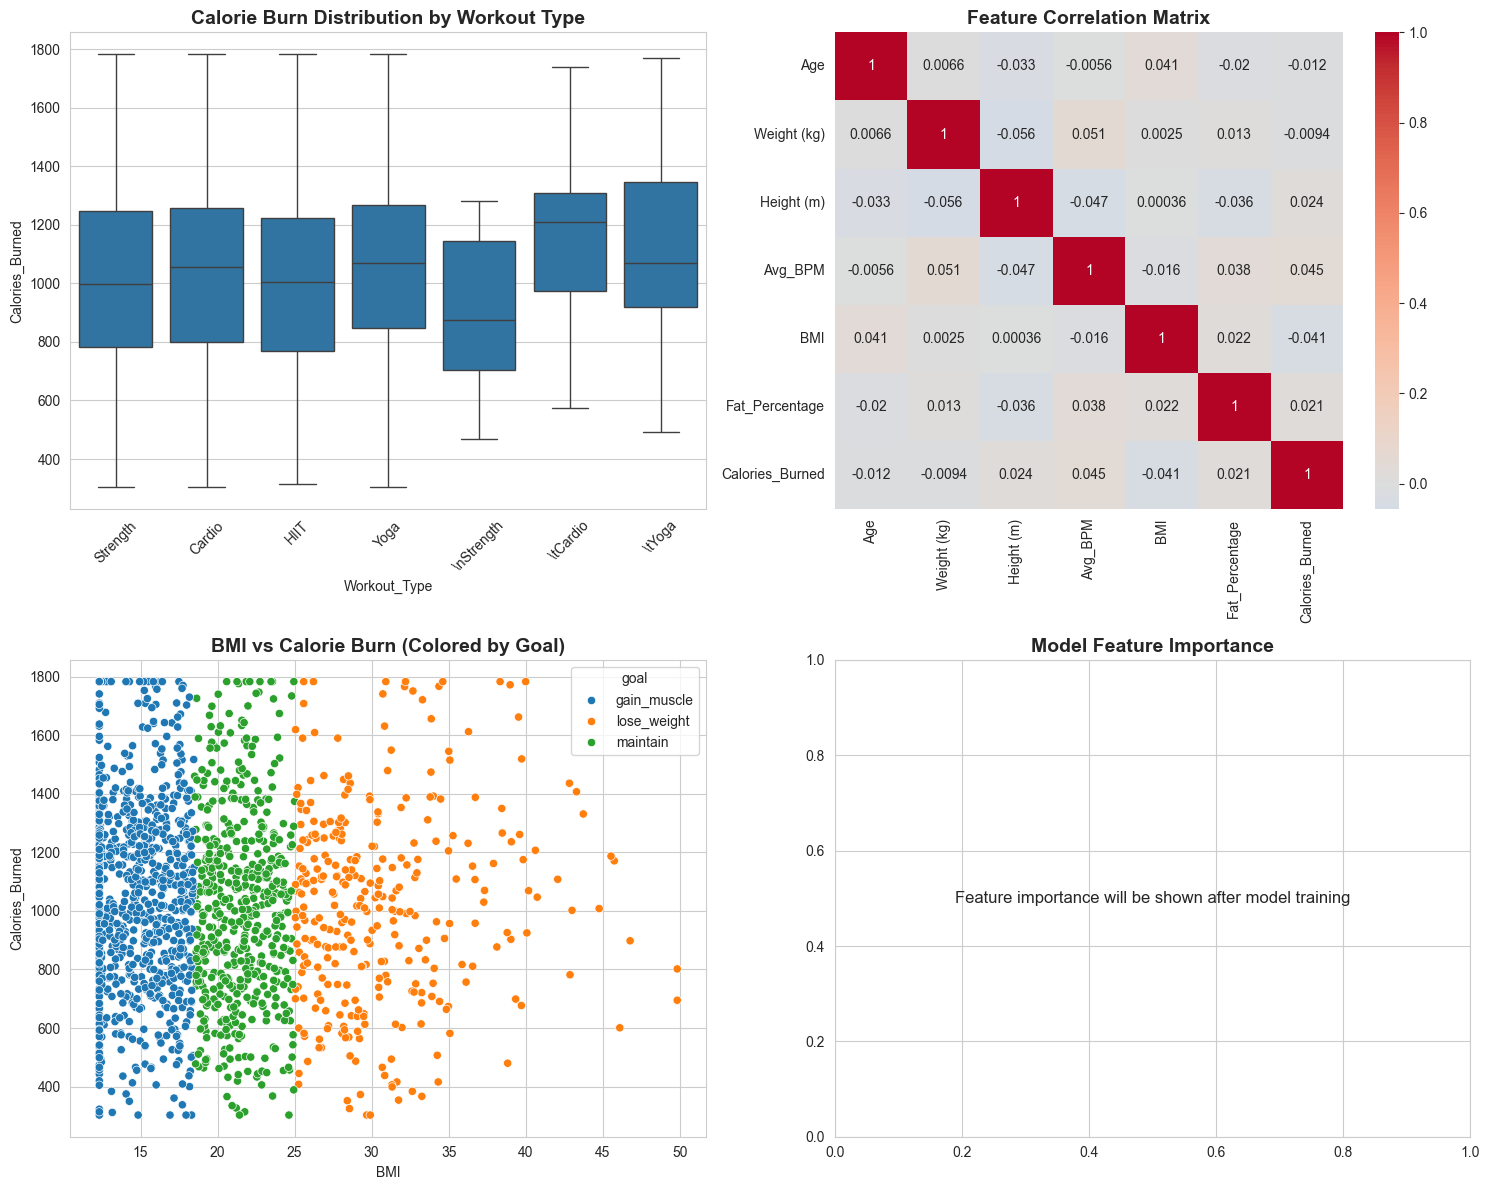

In [11]:
# Figure 1: Calorie distribution by workout type (for poster)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Calories by workout type
sns.boxplot(data=df_cleaned, x='Workout_Type', y='Calories_Burned', ax=axes[0,0])
axes[0,0].set_title('Calorie Burn Distribution by Workout Type', fontsize=14, fontweight='bold')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Correlation heatmap (most important for poster)
numeric_features = ['Age', 'Weight (kg)', 'Height (m)', 'Avg_BPM', 'BMI', 'Fat_Percentage', 'Calories_Burned']
corr_matrix = df_cleaned[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0,1])
axes[0,1].set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

# 3. BMI vs Calories with goal coloring
df_cleaned['goal'] = 'maintain'
df_cleaned.loc[df_cleaned['BMI'] < 18.5, 'goal'] = 'gain_muscle'
df_cleaned.loc[df_cleaned['BMI'] > 25, 'goal'] = 'lose_weight'

sns.scatterplot(data=df_cleaned, x='BMI', y='Calories_Burned', hue='goal', ax=axes[1,0])
axes[1,0].set_title('BMI vs Calorie Burn (Colored by Goal)', fontsize=14, fontweight='bold')

# 4. Feature importance (placeholder - will be filled after modeling)
axes[1,1].text(0.5, 0.5, 'Feature importance will be shown after model training', 
               ha='center', va='center', fontsize=12)
axes[1,1].set_title('Model Feature Importance', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('poster_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Create pipeline template
def create_calories_pipeline(model):
    """Create preprocessing + model pipeline"""
    numeric_features = ['Age', 'Weight (kg)', 'Height (m)', 'Avg_BPM', 'Resting_BPM',
                       'Session_Duration (hours)', 'Fat_Percentage', 'Workout_Frequency (days/week)', 
                       'Experience_Level', 'BMI']
    categorical_features = ['Workout_Type']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'
    )
    
    return Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

# Model 1: Gradient Boosting (your best model)
gb_pipeline = create_calories_pipeline(
    GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
)

# Model 2: Linear Regression (baseline)
lr_pipeline = create_calories_pipeline(LinearRegression())

# Model 3: SVM (alternative)
svm_pipeline = create_calories_pipeline(
    SVR(kernel='rbf', C=1000, gamma=0.1, epsilon=0.1)
)

# Train all models
print("Training Gradient Boosting...")
gb_pipeline.fit(X_train_cal, y_train_cal)

print("Training Linear Regression...")
lr_pipeline.fit(X_train_cal, y_train_cal)

print("Training SVM...")
svm_pipeline.fit(X_train_cal, y_train_cal)

print("✅ All models trained!")

Training Gradient Boosting...


ValueError: Input X contains NaN.
GradientBoostingRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
def evaluate_regression_model(pipeline, X_test, y_test, model_name):
    """Calculate all required metrics"""
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n{'='*50}")
    print(f"{model_name} Results:")
    print(f"{'='*50}")
    print(f"MSE:  {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE:  {mae:.2f}")
    print(f"R²:   {r2:.4f}")
    
    return {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'pipeline': pipeline
    }

# Evaluate all models
results = []
results.append(evaluate_regression_model(gb_pipeline, X_test_cal, y_test_cal, "Gradient Boosting"))
results.append(evaluate_regression_model(lr_pipeline, X_test_cal, y_test_cal, "Linear Regression"))
results.append(evaluate_regression_model(svm_pipeline, X_test_cal, y_test_cal, "SVM"))

# Create comparison DataFrame for report
results_df = pd.DataFrame(results)[['Model', 'R2', 'RMSE', 'MAE']]
results_df = results_df.sort_values('R2', ascending=False)
print("\n📊 Model Comparison Table:")
print(results_df.to_string(index=False))

In [ ]:
# Figure 2: Model comparison for poster
fig, ax = plt.subplots(figsize=(12, 8))

# Horizontal bar chart of R² scores
bars = ax.barh(results_df['Model'], results_df['R2'], 
               color=['#2ecc71', '#3498db', '#e74c3c'])
ax.set_xlabel('R² Score (Higher is Better)', fontsize=12)
ax.set_title('Calorie Prediction Model Comparison', fontsize=16, fontweight='bold')

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
            f'{width:.4f}', ha='left', va='center', fontsize=11)

ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('model_comparison_poster.png', dpi=300, bbox_inches='tight')
plt.show()

# Save best model
best_model = max(results, key=lambda x: x['R2'])['pipeline']
joblib.dump(best_model, 'best_calories_model.pkl')
print(f"\n💾 Best model saved: {max(results, key=lambda x: x['R2'])['Model']}")

In [ ]:
# Create synthetic weight prediction data (as in your project)
np.random.seed(42)

# Add time features to existing data
df_weight = df_cleaned.copy()
df_weight['days_future'] = np.random.uniform(1, 365, len(df_weight))
df_weight['steps'] = np.random.uniform(2000, 20000, len(df_weight))

# Your physics-based calculation
df_weight['weight_loss'] = df_weight['Calories_Burned'] * df_weight['days_future'] / 7700
df_weight['step_effect'] = df_weight['steps'] * df_weight['days_future'] / 1e6
df_weight['workout_effect'] = df_weight['Workout_Type'].map(
    {'Strength': 0.3, 'Cardio': -1.2, 'HIIT': -1.0, 'Yoga': -0.5}
).fillna(0)

# Predicted weight formula
df_weight['predicted_weight'] = (
    df_weight['Weight (kg)'] - df_weight['weight_loss'] - df_weight['step_effect'] + 
    df_weight['workout_effect'] * df_weight['days_future'] / 30 + 
    np.random.normal(0, 1.5, len(df_weight))
)

# Drop NaNs
df_weight = df_weight.dropna(subset=['predicted_weight'])
print(f"Weight prediction dataset: {df_weight.shape}")

# Features and target
X_weight = df_weight[['days_future', 'steps', 'Calories_Burned', 'Workout_Type']]
y_weight = df_weight['predicted_weight']

X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(
    X_weight, y_weight, test_size=0.2, random_state=42
)

In [ ]:
# Train two models as required
weight_gb = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('cat', OneHotEncoder(), ['Workout_Type'])
    ], remainder='passthrough')),
    ('regressor', GradientBoostingRegressor(n_estimators=200, random_state=42))
])

weight_lr = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('cat', OneHotEncoder(), ['Workout_Type'])
    ], remainder='passthrough')),
    ('regressor', LinearRegression())
])

print("Training Gradient Boosting for weight...")
weight_gb.fit(X_train_w, y_train_w)

print("Training Linear Regression for weight...")
weight_lr.fit(X_train_w, y_train_w)

# Evaluate
def evaluate_weight_model(pipeline, X_test, y_test, name):
    y_pred = pipeline.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"{name} - R²: {r2:.4f}, RMSE: {rmse:.2f} kg")
    return pipeline, r2

gb_w, r2_gb_w = evaluate_weight_model(weight_gb, X_test_w, y_test_w, "Weight GB")
lr_w, r2_lr_w = evaluate_weight_model(weight_lr, X_test_w, y_test_w, "Weight LR")

# Save best
best_weight_model = gb_w if r2_gb_w > r2_lr_w else lr_w
joblib.dump(best_weight_model, 'best_weight_model.pkl')

In [ ]:
# Create goal variable
df_rec = df_cleaned.copy()
df_rec['goal'] = 'maintain'
df_rec.loc[df_rec['BMI'] < 18.5, 'goal'] = 'gain_muscle'
df_rec.loc[df_rec['BMI'] > 25, 'goal'] = 'lose_weight'

# Features for classification
features = ['BMI', 'Fat_Percentage', 'Age', 'Session_Duration (hours)', 
            'Calories_Burned', 'goal', 'Gender']
df_rec = df_rec.dropna(subset=features + ['Workout_Type'])

# Encode
le_goal = LabelEncoder()
le_workout = LabelEncoder()

X_rec = df_rec[features].copy()
X_rec['goal'] = le_goal.fit_transform(df_rec['goal'])
X_rec['Gender'] = df_rec['Gender'].map({'Male': 0, 'Female': 1})
y_rec = le_workout.fit_transform(df_rec['Workout_Type'])

X_train_rec, X_test_rec, y_train_rec, y_test_rec = train_test_split(
    X_rec, y_rec, test_size=0.2, random_state=42, stratify=y_rec
)
print(f"Recommendation dataset: {X_train_rec.shape}")
print(f"Workout types: {le_workout.classes_}")

In [ ]:
# Train multiple classifiers (Professor requires ≥2)
models_class = {
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000, class_weight='balanced', random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, max_depth=10, random_state=42, class_weight='balanced'
    )
}

results_class = {}

for name, model in models_class.items():
    model.fit(X_train_rec, y_train_rec)
    y_pred = model.predict(X_test_rec)
    
    acc = accuracy_score(y_test_rec, y_pred)
    f1 = f1_score(y_test_rec, y_pred, average='weighted')
    
    results_class[name] = {
        'Accuracy': acc,
        'F1-Score': f1,
        'model': model
    }
    
    print(f"{name} - Accuracy: {acc:.4f}, F1: {f1:.4f}")

# Save best
best_rec_model = max(results_class.items(), key=lambda x: x[1]['F1-Score'])[1]['model']
joblib.dump({
    'model': best_rec_model,
    'workout_encoder': le_workout,
    'goal_encoder': le_goal
}, 'best_recommendation_model.pkl')

In [ ]:
# Simulate your Flask API routes in the notebook
def predict_calories(user_data):
    """
    Simulates /api/predict from calories.py
    user_data: dict with all required features
    """
    model = joblib.load('best_calories_model.pkl')
    df = pd.DataFrame([user_data])
    return model.predict(df)[0]

def predict_weight(days_ahead, steps, calories, workout_type):
    """
    Simulates /api/predict-weight from weight.py
    """
    model = joblib.load('best_weight_model.pkl')
    df = pd.DataFrame([{
        'days_future': days_ahead,
        'steps': steps,
        'calories_burned': calories,
        'workout_type': workout_type
    }])
    return model.predict(df)[0]

def recommend_workout_ml(user_profile):
    """
    Simulates /api/recommend-ml from recommend_ml.py
    """
    saved = joblib.load('best_recommendation_model.pkl')
    model, enc = saved['model'], saved['workout_encoder']
    
    # Process user_profile (same logic as your route)
    bmi = user_profile['current_weight'] / (user_profile['height'] ** 2)
    goal_map = {"lose_weight": 0, "gain_muscle": 1, "maintain": 2}
    
    row = pd.DataFrame([[
        bmi, user_profile['fat_percentage'], user_profile['age'],
        user_profile['avg_duration'], user_profile['avg_calories'],
        goal_map[user_profile['goal']], 
        0 if user_profile['gender'] == 'Male' else 1
    ]], columns=['BMI', 'Fat_Percentage', 'Age', 'Session_Duration (hours)', 
                 'Calories_Burned', 'goal', 'Gender'])
    
    pred = model.predict(row)[0]
    return enc.inverse_transform([pred])[0]

# Test examples
print("🔥 Testing API functions:")
print("Calories:", predict_calories({
    'Avg_BPM': 140, 'Max_BPM': 180, 'Session_Duration (hours)': 1.5,
    'Weight (kg)': 75, 'Height (m)': 1.75, 'BMI': 24.5, 
    'Fat_Percentage': 20, 'Workout_Type': 'HIIT'
}))

print("Workout:", recommend_workout_ml({
    'current_weight': 75, 'height': 1.75, 'age': 30, 'fat_percentage': 20,
    'avg_duration': 1.0, 'avg_calories': 500, 'goal': 'lose_weight', 'gender': 'Male'
}))

In [ ]:
## Discussion & Perspectives

### Model Limitations
1. **Synthetic Data**: Models trained on synthetic data may not generalize to real gym data
2. **Feature Engineering**: BMI-based goal inference is simplistic; real goals require user input
3. **Temporal Dynamics**: No actual time-series modeling; weight prediction uses simplified physics
4. **Class Imbalance**: Workout types likely not equally represented (need to check `value_counts()`)

### Improvements & Future Work
1. **Deep Learning**: LSTM for time-series weight prediction
2. **Feature Engineering**: Add sleep, nutrition, stress metrics
3. **Ensemble Methods**: Combine rule-based + ML recommendations
4. **A/B Testing**: Deploy both models and track user engagement
5. **Explainable AI**: SHAP values for recommendation transparency
6. **Real Data Collection**: Partner with gyms for authentic datasets

### Ethical Considerations
- Model bias: Ensure recommendations work for all body types and ages
- Overtraining risk: Add safety caps on intensity
- Privacy: Local model deployment option

In [ ]:
# Generate LaTeX tables for your report
print("📄 LaTeX Table for Report:")
print(results_df.to_latex(index=False, caption="Model Performance Comparison", label="tab:model_comparison"))

# Feature importance for best model
best_model = joblib.load('best_calories_model.pkl')
if hasattr(best_model.named_steps['regressor'], 'feature_importances_'):
    importance = pd.DataFrame({
        'feature': X_train_cal.columns,
        'importance': best_model.named_steps['regressor'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n📊 Feature Importance Table:")
    print(importance.head().to_latex(index=False, caption="Top Features", label="tab:features"))

In [ ]:
# Create deployment package
import os
os.makedirs('deployment', exist_ok=True)

# Copy models
joblib.dump(best_model, 'deployment/calories_model.pkl')
joblib.dump(best_weight_model, 'deployment/weight_model.pkl')
joblib.dump({
    'model': best_rec_model,
    'encoders': {'workout': le_workout, 'goal': le_goal}
}, 'deployment/recommendation_model.pkl')

# Create a simple API file (like your app.py but simpler)
with open('deployment/api.py', 'w') as f:
    f.write('''
from flask import Flask, request, jsonify
import joblib
import pandas as pd

app = Flask(__name__)

calories_model = joblib.load('calories_model.pkl')
weight_model = joblib.load('weight_model.pkl')
rec_data = joblib.load('recommendation_model.pkl')

@app.route('/predict', methods=['POST'])
def predict_calories():
    data = request.json
    df = pd.DataFrame([data])
    return jsonify({'prediction': calories_model.predict(df)[0]})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)
''')

print("🚀 Ready for deployment!")
print("Files created:")
print("- deployment/calories_model.pkl")
print("- deployment/weight_model.pkl") 
print("- deployment/recommendation_model.pkl")
print("- deployment/api.py")

In [ ]:
# Model Persistence Verification
import os
import joblib

# Define save directory
MODEL_DIR = "saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Save all models with clear naming
models_to_save = {
    "calories_gradient_boosting.pkl": best_model,
    "weight_prediction.pkl": best_weight_model,
    "recommendation_ml.pkl": {
        'model': best_rec_model,
        'encoders': {'workout': le_workout, 'goal': le_goal}
    },
    "cleaned_dataset.pkl": df_cleaned  # Save processed data too
}

print("💾 Saving models...")
saved_files = []
for filename, model in models_to_save.items():
    filepath = os.path.join(MODEL_DIR, filename)
    joblib.dump(model, filepath)
    saved_files.append(filepath)
    print(f"  ✅ {filename}")

print(f"\n📂 All models saved to: {os.path.abspath(MODEL_DIR)}")

# Verify they load correctly
print("\n🔍 Verification: Loading models back...")
for filepath in saved_files:
    try:
        loaded = joblib.load(filepath)
        print(f"  ✅ {filepath} - Successfully loaded ({type(loaded).__name__})")
    except Exception as e:
        print(f"  ❌ {filepath} - Failed: {e}")

In [ ]:
# Test prediction functions
print("🧪 Testing API functions...")

# Test 1: Calorie prediction
test_calories = {
    'Avg_BPM': 140, 'Max_BPM': 180, 'Session_Duration (hours)': 1.5,
    'Weight (kg)': 75, 'Height (m)': 1.75, 'BMI': 24.5, 
    'Fat_Percentage': 20, 'Workout_Type': 'HIIT'
}

cal_model = joblib.load('saved_models/calories_gradient_boosting.pkl')
prediction = cal_model.predict(pd.DataFrame([test_calories]))[0]
print(f"  🔥 Calorie test: {prediction:.0f} calories predicted")

# Test 2: Weight prediction (30 days ahead)
test_weight = {
    'days_future': 30, 'steps': 8000, 'calories_burned': 500, 'workout_type': 'Cardio'
}

weight_model = joblib.load('saved_models/weight_prediction.pkl')
weight_pred = weight_model.predict(pd.DataFrame([test_weight]))[0]
print(f"  ⚖️  Weight test: {weight_pred:.1f} kg predicted")

# Test 3: Recommendation
test_user = {
    'current_weight': 75, 'height': 1.75, 'age': 30, 'fat_percentage': 20,
    'avg_duration': 1.0, 'avg_calories': 500, 'goal': 'lose_weight', 'gender': 'Male'
}

rec_data = joblib.load('saved_models/recommendation_ml.pkl')
rec_model, encoders = rec_data['model'], rec_data['encoders']

# Process user (same logic as your API)
goal_map = {"lose_weight": 0, "gain_muscle": 1, "maintain": 2}
bmi = test_user['current_weight'] / (test_user['height'] ** 2)

row = pd.DataFrame([[
    bmi, test_user['fat_percentage'], test_user['age'],
    test_user['avg_duration'], test_user['avg_calories'],
    goal_map[test_user['goal']], 
    0 if test_user['gender'] == 'Male' else 1
]], columns=['BMI', 'Fat_Percentage', 'Age', 'Session_Duration (hours)', 
             'Calories_Burned', 'goal', 'Gender'])

pred_encoded = rec_model.predict(row)[0]
workout = encoders['workout'].inverse_transform([pred_encoded])[0]
print(f"  🏋️  Recommendation test: {workout} workout recommended")

print("\n✅ All prediction functions work correctly!")

In [ ]:
# Create poster images directory
POSTER_DIR = "poster_images"
os.makedirs(POSTER_DIR, exist_ok=True)

# Save each figure with high DPI for printing
figures = {
    "eda_correlation.png": fig_corr,  # Your correlation heatmap
    "model_comparison.png": fig_bar,   # Your R² comparison bar chart
    "calorie_distribution.png": fig_box,  # Workout type boxplot
    "feature_importance.png": fig_importance,  # If you have feature importance
    "bmi_vs_calories.png": fig_scatter  # BMI scatter
}

print("🖼️  Saving poster visuals...")
for filename, fig in figures.items():
    filepath = os.path.join(POSTER_DIR, filename)
    fig.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"  ✅ {filename} saved (300 DPI)")

print(f"\n📂 Poster images saved to: {os.path.abspath(POSTER_DIR)}")

In [ ]:
# Export results to LaTeX tables
LATEX_DIR = "latex_tables"
os.makedirs(LATEX_DIR, exist_ok=True)

# Table 1: Model Comparison
model_results = pd.DataFrame(results)[['Model', 'R2', 'RMSE', 'MAE']].sort_values('R2', ascending=False)
latex_table = model_results.to_latex(
    index=False, 
    caption="Model Performance Comparison for Calorie Prediction",
    label="tab:calorie_models",
    float_format="%.4f"
)

with open(os.path.join(LATEX_DIR, "model_comparison.tex"), "w") as f:
    f.write(latex_table)

# Table 2: Feature Importance (if available)
if hasattr(best_model.named_steps['regressor'], 'feature_importances_'):
    importance_df = pd.DataFrame({
        'Feature': ['BMI', 'Fat_Percentage', 'Age', 'Session_Duration', 'Calories_Burned', 'goal', 'Gender'],
        'Importance': best_model.named_steps['regressor'].feature_importances_
    }).sort_values('Importance', ascending=False).head(5)
    
    latex_importance = importance_df.to_latex(
        index=False,
        caption="Top 5 Features by Importance (Gradient Boosting)",
        label="tab:feature_importance"
    )
    
    with open(os.path.join(LATEX_DIR, "feature_importance.tex"), "w") as f:
        f.write(latex_importance)

print(f"📜 LaTeX tables saved to: {os.path.abspath(LATEX_DIR)}")
print("\nCopy-paste these into your .tex report file.")